#CLUSTERING-BASED RECOMMENDER SYSTEMS

#Import Statements

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import seaborn as sns
import os
from sklearn import preprocessing

#Getting The data

In [2]:
# read Record dataset
df_order = pd.read_excel("Rec_sys_data.xlsx")
#read Customer Dataset
df_customer = pd.read_excel("Rec_sys_data.xlsx", sheet_name = 'customer')
# read product dataset
df_product = pd.read_excel("Rec_sys_data.xlsx", sheet_name = 'product')

In [4]:
df_order.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,DeliveryDate,Discount%,ShipMode,ShippingCost,CustomerID
0,536365,84029E,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.20,ExpressAir,30.12,17850
1,536365,71053,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.21,ExpressAir,30.12,17850
2,536365,21730,6,2010-12-01 08:26:00,2010-12-03 08:26:00,0.56,Regular Air,15.22,17850
3,536365,84406B,8,2010-12-01 08:26:00,2010-12-03 08:26:00,0.30,Regular Air,15.22,17850
4,536365,22752,2,2010-12-01 08:26:00,2010-12-04 08:26:00,0.57,Delivery Truck,5.81,17850


In [5]:
df_customer.head()

,CustomerID,Gender,Age,Income,Zipcode,Customer Segment
0,13089,male,53,High,8625,Small Business
1,15810,female,22,Low,87797,Small Business
2,15556,female,29,High,29257,Corporate
3,13137,male,29,Medium,97818,Middle class
4,16241,male,36,Low,79200,Small Business


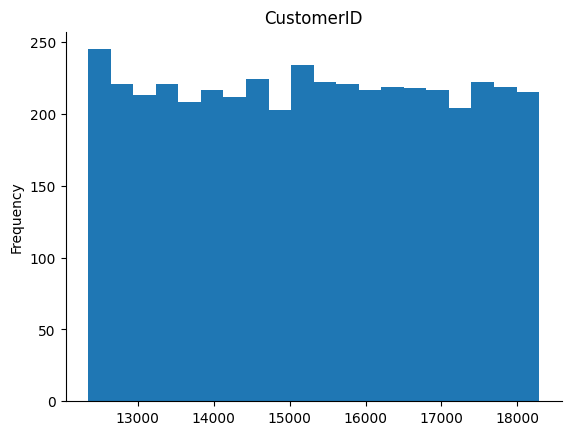

In [6]:
# @title CustomerID

from matplotlib import pyplot as plt
df_customer['CustomerID'].plot(kind='hist', bins=20, title='CustomerID')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
df_product.head()

,StockCode,Product Name,Description,Category,Brand,Unit Price
0,22629,Ganma Superheroes Ordinary Life Case For Samsu...,"New unique design, great gift.High quality pla...",Cell Phones|Cellphone Accessories|Cases & Prot...,Ganma,13.99
1,21238,Eye Buy Express Prescription Glasses Mens Wome...,Rounded rectangular cat-eye reading glasses. T...,Health|Home Health Care|Daily Living Aids,Eye Buy Express,19.22
2,22181,MightySkins Skin Decal Wrap Compatible with Ni...,Each Nintendo 2DS kit is printed with super-hi...,Video Games|Video Game Accessories|Accessories...,Mightyskins,14.99
3,84879,Mediven Sheer and Soft 15-20 mmHg Thigh w/ Lac...,The sheerest compression stocking in its class...,Health|Medicine Cabinet|Braces & Supports,Medi,62.38
4,84836,Stupell Industries Chevron Initial Wall D cor,Features: -Made in the USA. -Sawtooth hanger o...,Home Improvement|Paint|Wall Decals|All Wall De...,Stupell Industries,35.99


#Data Preprocessing

Checking for missing values:

In [8]:
def missing_zero_values_table(df):
    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(columns={0: 'Zero Values', 1: 'Missing Values', 2: '% of Total Values'})
    mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
    mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table[mz_table.iloc[:, 1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    print("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n" "There are " + str(mz_table.shape[0]) + " columns that have missing values.")
    return mz_table


In [9]:
missing_zero_values_table(df_customer)

Your selected dataframe has 6 columns and 4372 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


#EDA

In [11]:
# Age distribution

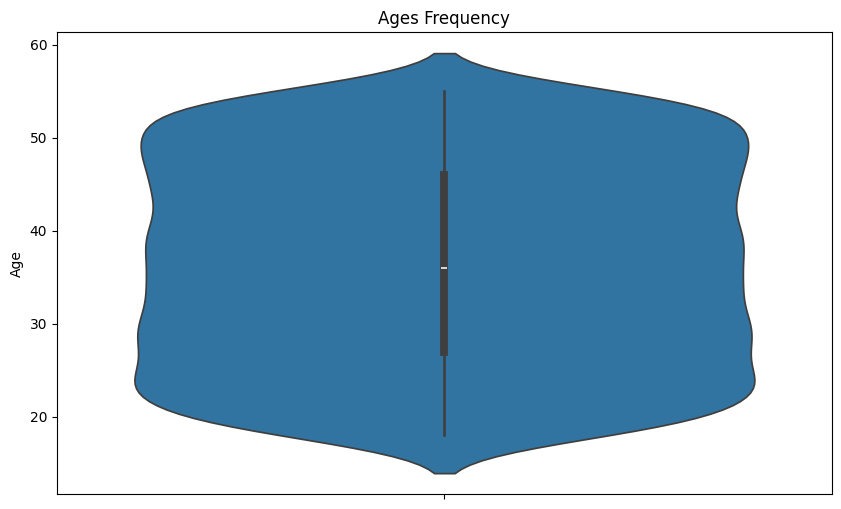

In [10]:
# Count of age Category
plt.figure(figsize=(10,6))
plt.title("Ages Frequency")
sns.axes_style("dark")
sns.violinplot(y=df_customer["Age"])
plt.show()

In [12]:
# Gender distribution

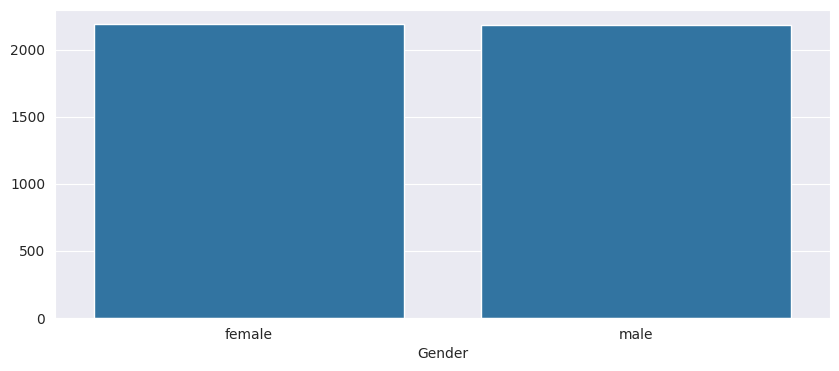

In [13]:
# Count of gender Category
genders = df_customer.Gender.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
sns.barplot(x=genders.index, y=genders.values)
plt.show()

In [14]:
# The key insight from this chart is that data is not biased based on gender.
# Let’s create buckets of age columns and plot them against the number of customers.

<ipython-input-15-1939fc620b4a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, palette="rocket")


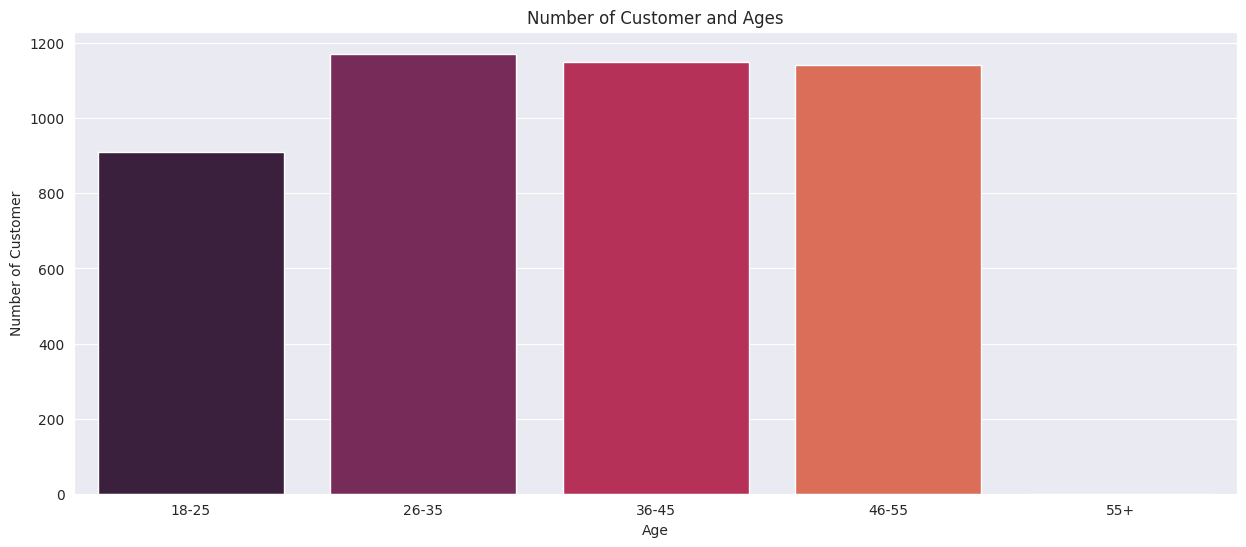

In [15]:
# age buckets against number of customers
age18_25 = df_customer.Age[(df_customer.Age <= 25) & (df_customer.Age >= 18)]
age26_35 = df_customer.Age[(df_customer.Age <= 35) & (df_customer.Age >= 26)]
age36_45 = df_customer.Age[(df_customer.Age <= 45) & (df_customer.Age >= 36)]
age46_55 = df_customer.Age[(df_customer.Age <= 55) & (df_customer.Age >= 46)]
age55above = df_customer.Age[df_customer.Age >= 56]

x = ["18-25","26-35","36-45","46-55","55+"]
y = [len(age18_25.values),len(age26_35.values),len(age36_45.values),len(age46_55.values),len(age55above.values)]

# Graphic
plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("Number of Customer and Ages")
plt.xlabel("Age")
plt.ylabel("Number of Customer")

plt.show()


In [16]:
# We see that there are fewer customers ages 18 to 25.

#Label Encoding

In [17]:
# label_encoder object knows how to understand word labels.
gender_encoder = preprocessing.LabelEncoder()
segment_encoder = preprocessing.LabelEncoder()
income_encoder = preprocessing.LabelEncoder()

# Encode labels in column
df_customer['age'] = df_customer.Age
df_customer['gender']= gender_encoder.fit_transform(df_customer['Gender'])
df_customer['customer_segment']= segment_encoder.fit_transform(df_customer['Customer Segment'])
df_customer['income_segment']= income_encoder.fit_transform(df_customer['Income'])

print("gender_encoder",df_customer['gender'].unique())
print("segment_encoder",df_customer['customer_segment'].unique())
print("income_encoder",df_customer['income_segment'].unique())


gender_encoder [1 0]
segment_encoder [2 0 1]
income_encoder [0 1 2]


In [18]:
# After the encoding
df_customer.iloc[:,6:]

,age,gender,customer_segment,income_segment
0,53,1,2,0
1,22,0,2,1
2,29,0,0,0
3,29,1,1,2
4,36,1,2,1
...,...,...,...,...
4367,22,0,0,0
4368,23,1,1,0
4369,40,1,1,2
4370,37,1,1,2


#Modeling

##K-Means Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

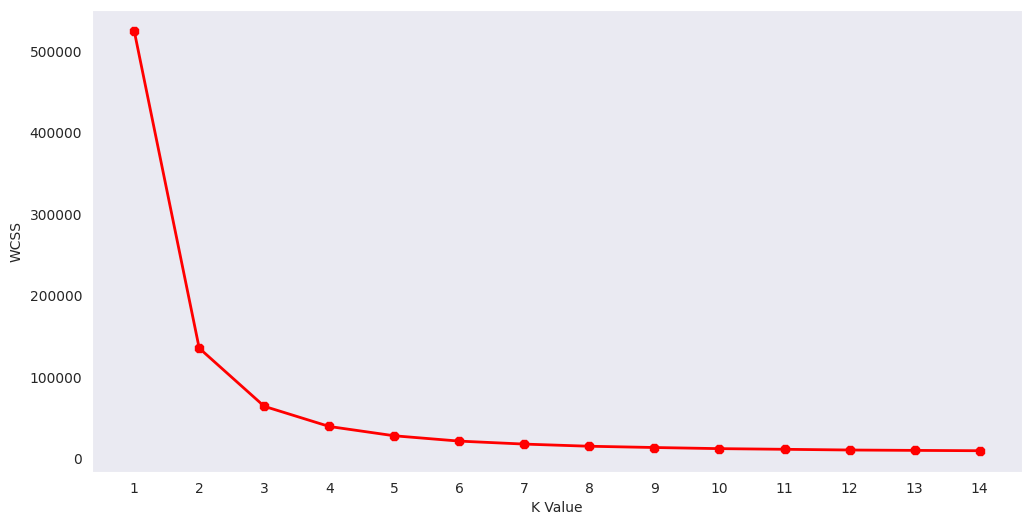

income_encoder [0 1 2]


In [19]:
# Elbow method
wcss = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df_customer.iloc[:, 6:])
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(range(1, 15), wcss, linewidth=2, color="red", marker="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1, 15, 1))
plt.ylabel("WCSS")
plt.show()

print("income_encoder", df_customer['income_segment'].unique())


In [22]:
# Function to plot dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(df_customer.iloc[:, 6:])


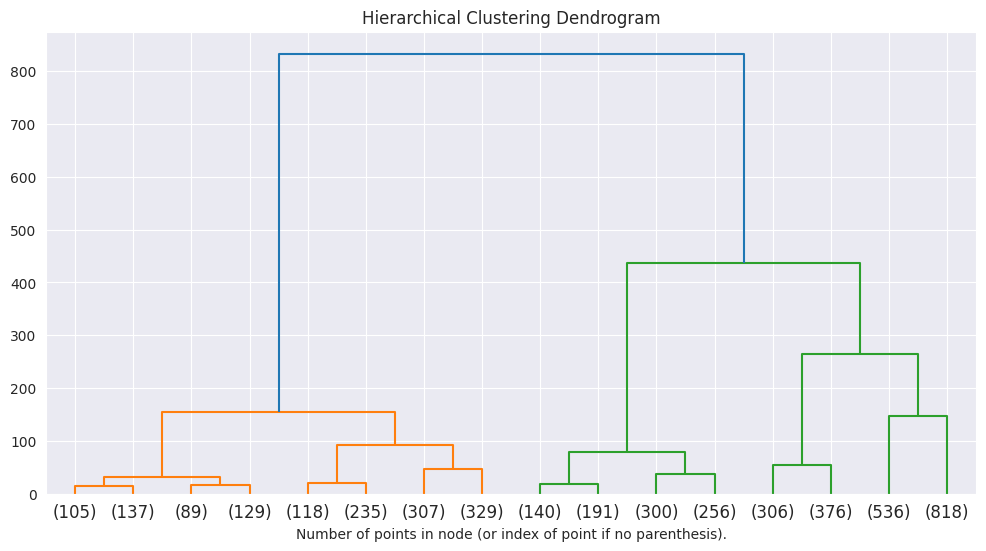

In [23]:
plt.figure(figsize=(12, 6))

plt.title("Hierarchical Clustering Dendrogram")
# Plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [24]:
# The optimal or least number of clusters for both methods is two. But let’s consider 15
# clusters for this use case.

In [25]:
# Let’s build a k-means algorithm considering 15 clusters.
# K-means
# Perform kmeans
km = KMeans(n_clusters=15)
clusters = km.fit_predict(df_customer.iloc[:,6:])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [26]:
clusters

array([ 8, 14, 12, ...,  4,  9,  6], dtype=int32)

In [27]:
# saving prediction back to raw dataset
df_customer['cluster'] = clusters
df_customer

,CustomerID,Gender,Age,Income,Zipcode,Customer Segment,age,gender,customer_segment,income_segment,cluster
0,13089,male,53,High,8625,Small Business,53,1,2,0,8
1,15810,female,22,Low,87797,Small Business,22,0,2,1,14
2,15556,female,29,High,29257,Corporate,29,0,0,0,12
3,13137,male,29,Medium,97818,Middle class,29,1,1,2,12
4,16241,male,36,Low,79200,Small Business,36,1,2,1,9
...,...,...,...,...,...,...,...,...,...,...,...
4367,17763,female,22,High,57980,Corporate,22,0,0,0,14
4368,16078,male,23,High,38622,Middle class,23,1,1,0,0
4369,13270,male,40,Medium,57985,Middle class,40,1,1,2,4
4370,15562,male,37,Medium,91274,Middle class,37,1,1,2,9


In [28]:
# Select the required columns from the dataset.
df_customer = df_customer[['CustomerID', 'Gender', 'Age', 'Income','Zipcode', 'Customer Segment', 'cluster']]
df_customer

,CustomerID,Gender,Age,Income,Zipcode,Customer Segment,cluster
0,13089,male,53,High,8625,Small Business,8
1,15810,female,22,Low,87797,Small Business,14
2,15556,female,29,High,29257,Corporate,12
3,13137,male,29,Medium,97818,Middle class,12
4,16241,male,36,Low,79200,Small Business,9
...,...,...,...,...,...,...,...
4367,17763,female,22,High,57980,Corporate,14
4368,16078,male,23,High,38622,Middle class,0
4369,13270,male,40,Medium,57985,Middle class,4
4370,15562,male,37,Medium,91274,Middle class,9


Performing analysis on cluste level

In [29]:
# function to plot charts of clusters against the column given.

In [34]:
# def plotting_percentages(df, col, target):
#     x, y = col, target
#     # Temporary dataframe with percentage values
#     temp_df = df.groupby(x)[y].value_counts(normalize=True)
#     temp_df = temp_df.mul(100).rename('percent').reset_index()
#     # Sort the column values for plotting
#     order_list = list(df[col].unique())
#     order_list.sort()
#     # Plot the figure
#     sns.set(font_scale=1.5)
#     g = sns.catplot(x=x, y='percent', hue=y, kind='bar', data=temp_df,
#                     height=8, aspect=2, order=order_list, legend_out=False)
#     g.ax.set_ylim(0, 100)
#     # Loop through each bar in the graph and add the percentage value
#     for p in g.ax.patches:
#         txt = str(p.get_height().round(1)) + '%'
#         txt_x = p.get_x()
#         txt_y = p.get_height()
#         g.ax.text(txt_x, txt_y, txt)
#     # Set labels and title
#     plt.title(f'{col.title()} By Percent {target.title()}',
#               fontdict={'fontsize': 30})
#     plt.xlabel(f'{col.title()}', fontdict={'fontsize': 20})
#     plt.ylabel(f'{target.title()} Percentage', fontdict={'fontsize': 20})
#     plt.xticks(rotation=75)
#     return g


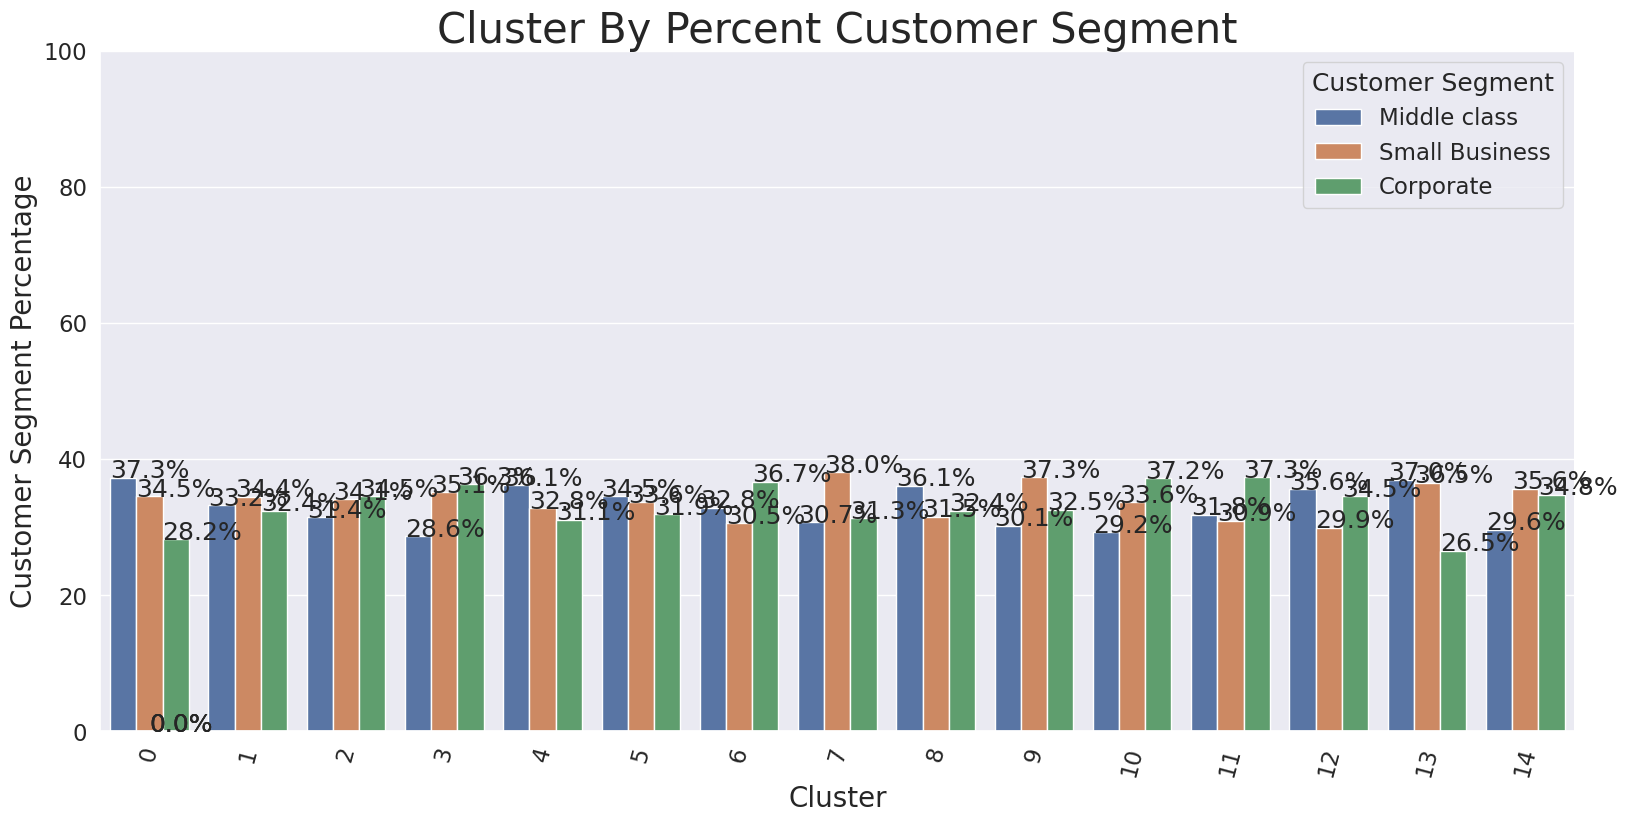

In [32]:
def plotting_percentages(df, col, target):
    x, y = col, target
    # Temporary dataframe with percentage values
    temp_df = df.groupby(x)[y].value_counts(normalize=True)
    temp_df = temp_df.mul(100).rename('percent').reset_index()
    # Sort the column values for plotting
    order_list = list(df[col].unique())
    order_list.sort()
    # Plot the figure
    sns.set(font_scale=1.5)
    g = sns.catplot(x=x, y='percent', hue=y, kind='bar', data=temp_df,
                    height=8, aspect=2, order=order_list, legend_out=False)
    g.ax.set_ylim(0, 100)
    # Loop through each bar in the graph and add the percentage value
    for p in g.ax.patches:
        # Convert height to float before rounding
        height = float(p.get_height())
        txt = str(round(height, 1)) + '%'  # Round the height to one decimal place
        txt_x = p.get_x()
        txt_y = p.get_height()
        g.ax.text(txt_x, txt_y, txt)
    # Set labels and title
    plt.title(f'{col.title()} By Percent {target.title()}',
              fontdict={'fontsize': 30})
    plt.xlabel(f'{col.title()}', fontdict={'fontsize': 20})
    plt.ylabel(f'{target.title()} Percentage', fontdict={'fontsize': 20})
    plt.xticks(rotation=75)
    return g

# Plot the customer segment.
plotting_percentages(df_customer, 'cluster', 'Customer Segment')


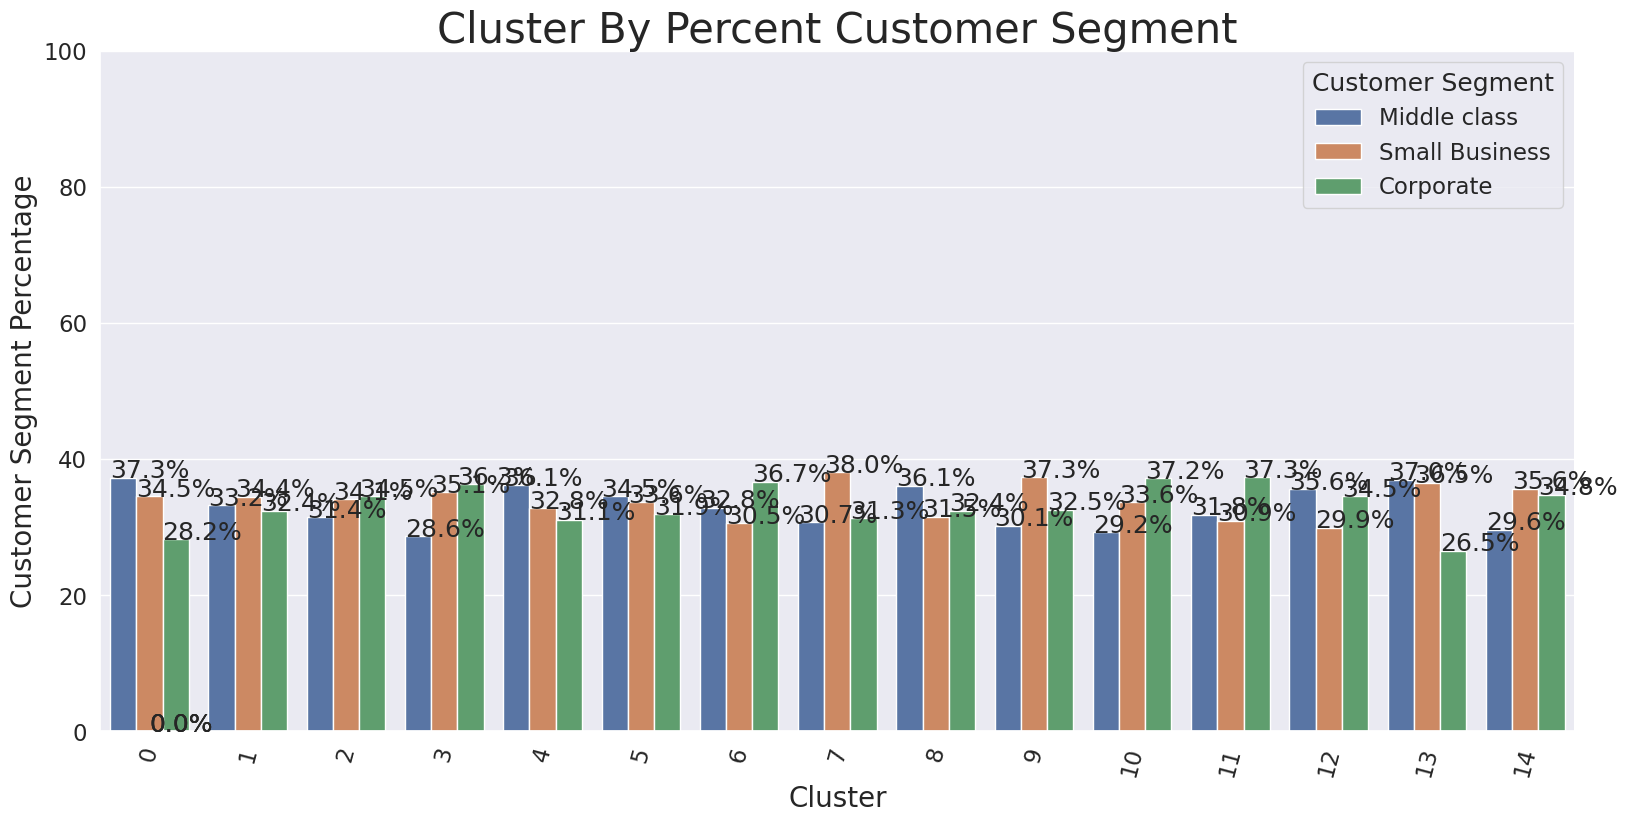

In [33]:
# Plot the customer segment.
plotting_percentages(df_customer, 'cluster', 'Customer Segment')

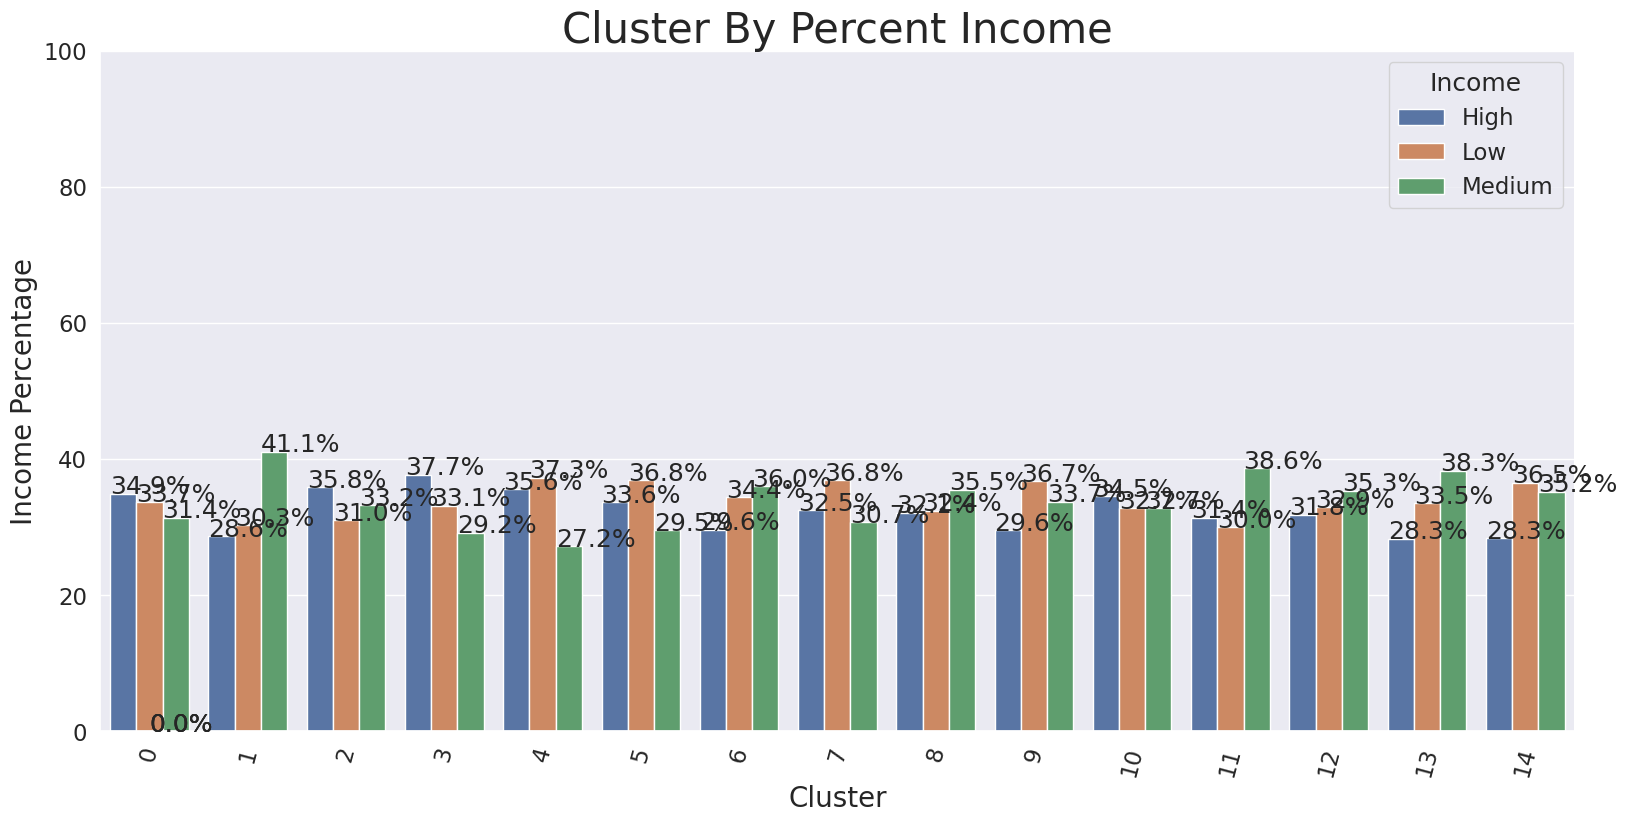

In [35]:
# plot income.
plotting_percentages(df_customer, 'cluster', 'Income')

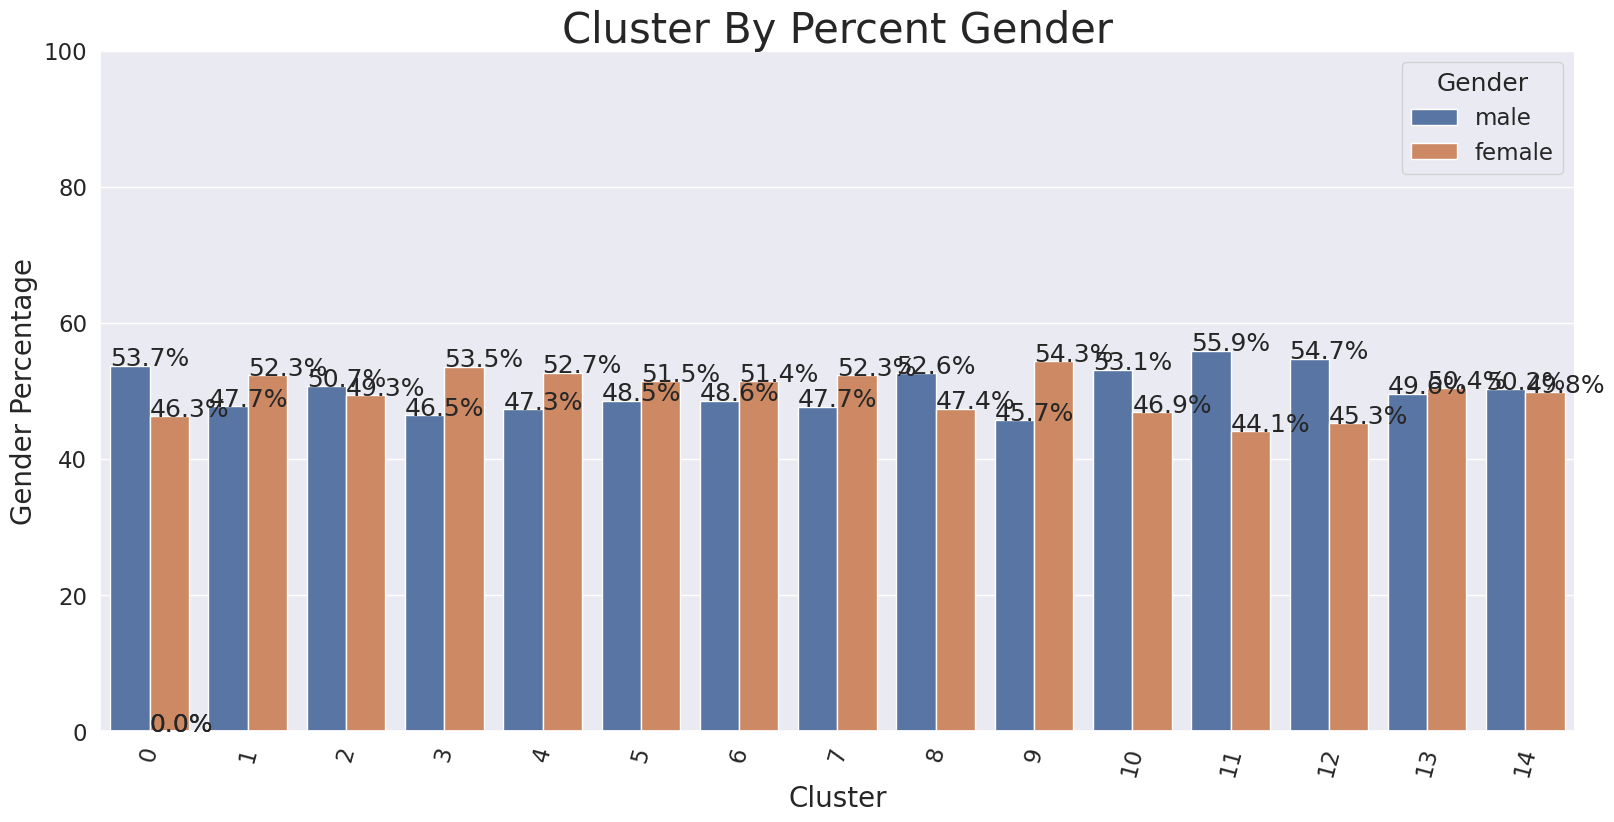

In [36]:
# Gender
plotting_percentages(df_customer, 'cluster', 'Gender')

<Axes: xlabel='cluster'>

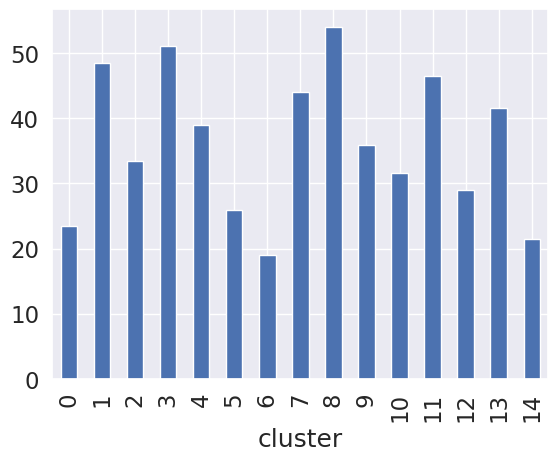

In [37]:
# Average age per cluster
df_customer.groupby('cluster').Age.mean().plot(kind='bar')

In [38]:
# join customer data with the order data to get the product ID for each record.
order_cluster_mapping = pd.merge( df_order,df_customer, on='CustomerID',how='inner')[['StockCode','CustomerID','cluster']]
order_cluster_mapping

,StockCode,CustomerID,cluster
0,84029E,17850,1
1,71053,17850,1
2,21730,17850,1
3,84406B,17850,1
4,22752,17850,1
...,...,...,...
272399,21818,17666,13
272400,21817,17666,13
272401,23329,17666,13
272402,71459,17666,13


In [40]:
# let’s create score_df using groupby on 'cluster' and 'StockCode', and count it.
score_df = order_cluster_mapping.groupby(['cluster','StockCode']).count().reset_index()
score_df = score_df.rename(columns={'CustomerID':'Score'})
score_df

,cluster,StockCode,Score
0,0,10002,4
1,0,10120,2
2,0,10125,4
3,0,10133,8
4,0,10135,6
...,...,...,...
37001,14,90201C,1
37002,14,90201D,1
37003,14,BANK CHARGES,2
37004,14,M,21


In [41]:
# The score_df data is ready to recommend new products to a customer. Other
# customers in the same cluster have bought the recommended products. This is based on
# similar users.

In [42]:
# Work on product data to recommend products based on similarity.

In [43]:
missing_zero_values_table(df_product)

Your selected dataframe has 6 columns and 29912 Rows.
There are 6 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
StockCode,0,25954,86.8,25954,86.8,object
Product Name,0,25954,86.8,25954,86.8,object
Description,0,25954,86.8,25954,86.8,object
Brand,0,1129,3.8,1129,3.8,object
Category,0,792,2.6,792,2.6,object
Unit Price,0,118,0.4,118,0.4,float64


In [44]:
# Cleaning
df_product = df_product.dropna()
missing_zero_values_table(df_product)

Your selected dataframe has 6 columns and 3706 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [45]:
# Pre-processing step: remove words like we'll, you'll, they'll etc.
df_product['Description'] = df_product['Description'].replace({"'ll": " "},regex=True)
df_product['Description'] = df_product['Description'].replace({"-": " "},regex=True)
df_product['Description'] = df_product['Description'].replace({"[^A-Za-z0-9]+": ""}, regex=True)

In [46]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
#converting text to features
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_product['Description'])

In [49]:
X

<3706x715 sparse matrix of type '<class 'numpy.float64'>'
	with 3700 stored elements in Compressed Sparse Row format>

In [50]:
#clustering your products based on text
km_des = KMeans(n_clusters=15,init='k-means++')
clusters = km_des.fit_predict(X)
df_product['cluster'] = clusters
df_product

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,StockCode,Product Name,Description,Category,Brand,Unit Price,cluster
0,22629,Ganma Superheroes Ordinary Life Case For Samsu...,NewuniquedesigngreatgiftHighqualityplasticmate...,Cell Phones|Cellphone Accessories|Cases & Prot...,Ganma,13.99,0
1,21238,Eye Buy Express Prescription Glasses Mens Wome...,RoundedrectangularcateyereadingglassesThesefra...,Health|Home Health Care|Daily Living Aids,Eye Buy Express,19.22,0
2,22181,MightySkins Skin Decal Wrap Compatible with Ni...,EachNintendo2DSkitisprintedwithsuperhighresolu...,Video Games|Video Game Accessories|Accessories...,Mightyskins,14.99,0
3,84879,Mediven Sheer and Soft 15-20 mmHg Thigh w/ Lac...,Thesheerestcompressionstockinginitsclassisexac...,Health|Medicine Cabinet|Braces & Supports,Medi,62.38,4
4,84836,Stupell Industries Chevron Initial Wall D cor,FeaturesMadeintheUSASawtoothhangeronthebackfor...,Home Improvement|Paint|Wall Decals|All Wall De...,Stupell Industries,35.99,0
...,...,...,...,...,...,...,...
3953,84612B,Home Cardboard Flower Print Travel Memo Collec...,SpecialdesigneasytoinsertandremoveyourphotosSa...,"Arts, Crafts & Sewing|Scrapbooking|Albums & Re...",Unique Bargains,20.99,0
3954,47502,6 1/4 x 6 1/4 Gatefold Invitation - Mandarin O...,AnnounceyoureventusingaclassicGatefoldstyleinv...,Office|Envelopes & Mailing Supplies|Envelopes,Envelopes.com,55.23,0
3955,84546,"Three Things That Makes Good Coffee: Sugar, Su...",ProductFeaturesSize35inx18inColorLightpinkDeli...,Home Improvement|Paint|Wall Decals|All Wall De...,Style & Apply,39.95,0
3956,21923,Women's Breeze Walker,Suppleleatherupperswithliningthreeadjustablest...,Clothing|Shoes|Womens Shoes|All Womens Shoes,Prop?t,76.95,5


In [51]:
# df_product data is ready to recommend the products based on similar items.
# Let’s write a function that recommends products based on item and user similarity

In [52]:
# functions to recommend products based on item and user similarity.
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer

from nltk.corpus import stopwords
import pandas as pd

In [57]:
# # function to find cosine similarity after converting description column to features using TF-IDF
# def cosine_similarity_T(df, query):
#     vec = TfidfVectorizer(analyzer='word', stop_words=ENGLISH_STOP_WORDS)
#     vec_train = vec.fit_transform(df.Description)
#     vec_query = vec.transform([query])
#     within_cosine_similarity = []
#     for i in range(len(vec_train.todense())):
#         within_cosine_similarity.append(cosine_similarity(vec_train[i, :].toarray(), vec_query.toarray())[0][0])
#     df['Similarity'] = within_cosine_similarity
#     return df

In [55]:
def cosine_similarity_T(df, query):
    vec = TfidfVectorizer(analyzer='word', stop_words='english')
    vec_train = vec.fit_transform(df.Description)
    vec_query = vec.transform([query])
    within_cosine_similarity = []
    for i in range(len(vec_train.todense())):
        within_cosine_similarity.append(cosine_similarity(vec_train[i, :].toarray(), vec_query.toarray())[0][0])
    df['Similarity'] = within_cosine_similarity
    return df


In [56]:
def recommend_product(customer_id):
    # filter for the particular customer
    cluster_score_df = score_df[score_df.cluster == order_cluster_mapping[order_cluster_mapping.CustomerID == customer_id]['cluster'].iloc[0]]
    # filter top 5 stock codes for recommendation
    top_5_non_bought = cluster_score_df[~cluster_score_df.StockCode.isin(order_cluster_mapping[order_cluster_mapping.CustomerID == customer_id]['StockCode'])].nlargest(5, 'Score')
    print('\n--- top 5 StockCode - Non bought --------\n')
    print(top_5_non_bought)
    print('\n-------Recommendations Non bought ------\n')

    cust_orders = df_order[df_order.CustomerID == customer_id][['CustomerID', 'StockCode']]
    top_orders = cust_orders.groupby(['StockCode']).count().reset_index()
    top_orders = top_orders.rename(columns={'CustomerID': 'Counts'})
    top_orders['CustomerID'] = customer_id
    top_5_bought = top_orders.nlargest(5, 'Counts')
    print('\n--- top 5 StockCode - bought --------\n')
    print(top_5_bought)
    print('\n-------Stock code Product (Bought) - Description cluster Mapping------\n')
    top_clusters = df_product[df_product.StockCode.isin(top_5_bought.StockCode.tolist())][['StockCode', 'cluster']]
    print(top_clusters)
    df = df_product[df_product['cluster'] == df_product[df_product.StockCode == top_clusters.StockCode.iloc[0]]['cluster'].iloc[0]]
    query = df_product[df_product.StockCode == top_clusters.StockCode.iloc[0]]['Description'].iloc[0]
    print("\nquery\n")
    print(query)
    recommendation = cosine_similarity_T(df, query)
    print(recommendation.nlargest(3, 'Similarity'))

recommend_product(13137)



--- top 5 StockCode - Non bought --------

       cluster StockCode  Score
32362       12    85123A    148
30845       12     22423    101
31803       12     47566     94
30878       12     22457     77
31115       12     22720     73

-------Recommendations Non bought ------


--- top 5 StockCode - bought --------

    StockCode  Counts  CustomerID
23      21212       5       13137
24      21213       5       13137
86      22211       5       13137
101     22379       5       13137
8       20727       4       13137

-------Stock code Product (Bought) - Description cluster Mapping------

     StockCode  cluster
214      21212       10
372      22379        0
565      20727        0
636      22211        0
1129     21213        0

query

OurRusticCollectionisaninstantclassicOurRusticwoodmillworkutilizesthetechnologiesoftodaytobuildthelogandtimberwoodproductsthathavebeeninarchitectureforcenturiesBecauseourproductsarenotkilndriedeachiteminourRusticCollectionis100uniqueandwillcontainthena

<ipython-input-55-012e8f39e04c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Similarity'] = within_cosine_similarity
